# LoRA 모델 성능 비교 분석

이 노트북은 베이스 모델과 LoRA 가중치를 로딩한 모델의 성능을 비교하여 시각적으로 확인할 수 있습니다.

## 기능
- 베이스 모델 (SD/SDXL) 이미지 생성
- LoRA 가중치를 로딩한 모델 이미지 생성
- 두 모델의 결과를 나란히 비교
- 다양한 프롬프트로 성능 테스트
- 파라미터 조정 실험

In [1]:
# 필요한 라이브러리 import
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from enum import Enum
from typing import Any, Dict, Final, List, Tuple
from diffusers import StableDiffusionPipeline, DiffusionPipeline, EulerDiscreteScheduler
from diffusers.models import AutoencoderKL
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

/home/ubuntu/miniconda/envs/m_train/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 모델 ID 정의 (test_lora_local.py와 동일)
class HfModelId(str, Enum):
    # SD 모델
    SD_V1_5: str = "SG161222/Realistic_Vision_V5.1_noVAE"
    SD_VAE: str = "stabilityai/sd-vae-ft-mse"
    
    # SDXL 모델
    SDXL_V1_0_BASE: str = "stabilityai/stable-diffusion-xl-base-1.0"
    SDXL_V1_0_REFINER: str = "stabilityai/stable-diffusion-xl-refiner-1.0"

ENABLE_MODEL_CPU_OFFLOAD: Final = True
USE_REFINER: Final = False

In [3]:
# SD 모델 로딩 함수들
def load_sd_base_model() -> Any:
    """SD 베이스 모델 로딩 (LoRA 없이)"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading SD base model on device: {device}")

    model = StableDiffusionPipeline.from_pretrained(
        HfModelId.SD_V1_5.value, torch_dtype=torch.float16
    ).to(device)

    model.vae = AutoencoderKL.from_pretrained(
        HfModelId.SD_VAE.value, torch_dtype=torch.float16
    ).to(device)

    model.scheduler = EulerDiscreteScheduler.from_config(
        model.scheduler.config, use_karras_sigmas=True
    )

    return model

def load_sd_lora_model(model_dir: str) -> Any:
    """SD LoRA 모델 로딩 (베이스 + LoRA)"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading SD LoRA model on device: {device}")

    model = StableDiffusionPipeline.from_pretrained(
        HfModelId.SD_V1_5.value, torch_dtype=torch.float16
    ).to(device)

    model.vae = AutoencoderKL.from_pretrained(
        HfModelId.SD_VAE.value, torch_dtype=torch.float16
    ).to(device)

    model.scheduler = EulerDiscreteScheduler.from_config(
        model.scheduler.config, use_karras_sigmas=True
    )

    print(f"Loading LoRA weights from: {model_dir}")
    model.load_lora_weights(model_dir)

    return model

In [4]:
# SDXL 모델 로딩 함수들
def load_sdxl_base_model() -> Dict[str, Any]:
    """SDXL 베이스 모델 로딩 (LoRA 없이)"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading SDXL base model on device: {device}")

    model = DiffusionPipeline.from_pretrained(
        HfModelId.SDXL_V1_0_BASE.value,
        torch_dtype=torch.float16,
        variant="fp16",
    )
    
    _ = (
        model.enable_model_cpu_offload()
        if ENABLE_MODEL_CPU_OFFLOAD
        else model.to(device)
    )

    return {"model": model, "refiner": None}

def load_sdxl_lora_model(model_dir: str) -> Dict[str, Any]:
    """SDXL LoRA 모델 로딩 (베이스 + LoRA)"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading SDXL LoRA model on device: {device}")

    model = DiffusionPipeline.from_pretrained(
        HfModelId.SDXL_V1_0_BASE.value,
        torch_dtype=torch.float16,
        variant="fp16",
    )
    
    _ = (
        model.enable_model_cpu_offload()
        if ENABLE_MODEL_CPU_OFFLOAD
        else model.to(device)
    )

    print(f"Loading LoRA weights from: {model_dir}")
    model.load_lora_weights(model_dir)

    return {"model": model, "refiner": None}

In [5]:
# 이미지 생성 함수들
def generate_sd_image(model: Any, prompt: str, **kwargs) -> Image.Image:
    """SD 모델로 이미지 생성"""
    height = kwargs.get("height", 512)
    width = kwargs.get("width", 512)
    num_inference_steps = kwargs.get("num_inference_steps", 50)
    guidance_scale = kwargs.get("guidance_scale", 7.5)
    negative_prompt = kwargs.get("negative_prompt", None)
    num_images_per_prompt = kwargs.get("num_images_per_prompt", 1)
    seed = kwargs.get("seed", 42)
    cross_attention_scale = kwargs.get("cross_attention_scale", 0.5)

    negative_prompt = negative_prompt if negative_prompt and len(negative_prompt) > 0 else None
    device = "cuda" if torch.cuda.is_available() else "cpu"

    generator = torch.Generator(device=device).manual_seed(seed)
    generated_images = model(
        prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_images_per_prompt,
        generator=generator,
        cross_attention_kwargs={"scale": cross_attention_scale},
    )["images"]

    return generated_images[0]

def generate_sdxl_image(model_dict: Dict[str, Any], prompt: str, **kwargs) -> Image.Image:
    """SDXL 모델로 이미지 생성"""
    height = kwargs.get("height", 1024)
    width = kwargs.get("width", 1024)
    num_inference_steps = kwargs.get("num_inference_steps", 50)
    guidance_scale = kwargs.get("guidance_scale", 7.5)
    negative_prompt = kwargs.get("negative_prompt", None)
    num_images_per_prompt = kwargs.get("num_images_per_prompt", 1)
    seed = kwargs.get("seed", 42)
    high_noise_frac = kwargs.get("high_noise_frac", 0.7)
    cross_attention_scale = kwargs.get("cross_attention_scale", 0.5)

    negative_prompt = negative_prompt if negative_prompt and len(negative_prompt) > 0 else None
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model, refiner = model_dict["model"], model_dict["refiner"]
    generator = torch.Generator(device=device).manual_seed(seed)

    if USE_REFINER and refiner:
        image = model(
            prompt=prompt,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            denoising_end=high_noise_frac,
            generator=generator,
            output_type="latent",
            cross_attention_kwargs={"scale": cross_attention_scale},
        )["images"]
        generated_images = refiner(
            prompt=prompt,
            image=image,
            num_inference_steps=num_inference_steps,
            denoising_start=high_noise_frac,
        )["images"]
    else:
        generated_images = model(
            prompt=prompt,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            cross_attention_kwargs={"scale": cross_attention_scale},
        )["images"]

    return generated_images[0]

In [6]:
# 이미지 비교 시각화 함수
def compare_images(base_image: Image.Image, lora_image: Image.Image, 
                  prompt: str, model_type: str = "SDXL", 
                  figsize: Tuple[int, int] = (12, 6)):
    """베이스 모델과 LoRA 모델의 이미지를 나란히 비교하여 표시"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 베이스 모델 이미지
    ax1.imshow(base_image)
    ax1.set_title(f'{model_type} Base Model\n{prompt[:50]}{"..." if len(prompt) > 50 else ""}', 
                  fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # LoRA 모델 이미지
    ax2.imshow(lora_image)
    ax2.set_title(f'{model_type} LoRA Model\n{prompt[:50]}{"..." if len(prompt) > 50 else ""}', 
                  fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 이미지 정보 출력
    print(f"\n=== 이미지 비교 결과 ===")
    print(f"프롬프트: {prompt}")
    print(f"베이스 모델 이미지 크기: {base_image.size}")
    print(f"LoRA 모델 이미지 크기: {lora_image.size}")
    print(f"모델 타입: {model_type}")

In [7]:
# 설정
MODEL_TYPE = "SDXL"  # "SD" 또는 "SDXL"
LORA_PATH = "../models/"  # LoRA 가중치 경로

print(f"모델 타입: {MODEL_TYPE}")
print(f"LoRA 경로: {LORA_PATH}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

모델 타입: SDXL
LoRA 경로: ../models/
CUDA 사용 가능: True
GPU 메모리: 39.5 GB


In [8]:
# 모델 로딩
print("=== 모델 로딩 시작 ===")

if MODEL_TYPE == "SD":
    # SD 모델 로딩
    print("\n1. SD 베이스 모델 로딩 중...")
    sd_base_model = load_sd_base_model()
    
    print("\n2. SD LoRA 모델 로딩 중...")
    sd_lora_model = load_sd_lora_model(LORA_PATH)
    
    base_model = sd_base_model
    lora_model = sd_lora_model
    
else:
    # SDXL 모델 로딩
    print("\n1. SDXL 베이스 모델 로딩 중...")
    sdxl_base_model = load_sdxl_base_model()
    
    print("\n2. SDXL LoRA 모델 로딩 중...")
    sdxl_lora_model = load_sdxl_lora_model(LORA_PATH)
    
    base_model = sdxl_base_model
    lora_model = sdxl_lora_model

print("\n=== 모델 로딩 완료 ===")

=== 모델 로딩 시작 ===

1. SDXL 베이스 모델 로딩 중...
Loading SDXL base model on device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.89it/s]



2. SDXL LoRA 모델 로딩 중...
Loading SDXL LoRA model on device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Loading LoRA weights from: ../models/

=== 모델 로딩 완료 ===


In [9]:
# 테스트 프롬프트
test_prompts = [
    "a photo of a woman wearing fashion clothes",
    "a photo of a fashion model in street style",
    "a photo of a person wearing trendy outfit",
    "a photo of a woman in casual fashion"
]

# 기본 파라미터
params = {
    "num_inference_steps": 30,  # 빠른 테스트를 위해 줄임
    "guidance_scale": 7.5,
    "seed": 42,
    "cross_attention_scale": 0.5
}

if MODEL_TYPE == "SD":
    params.update({"height": 512, "width": 512})
else:
    params.update({"height": 1024, "width": 1024})

print(f"테스트 파라미터: {params}")

테스트 파라미터: {'num_inference_steps': 30, 'guidance_scale': 7.5, 'seed': 42, 'cross_attention_scale': 0.5, 'height': 1024, 'width': 1024}



=== 테스트 프롬프트: a photo of a woman wearing fashion clothes ===

1. 베이스 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]



2. LoRA 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


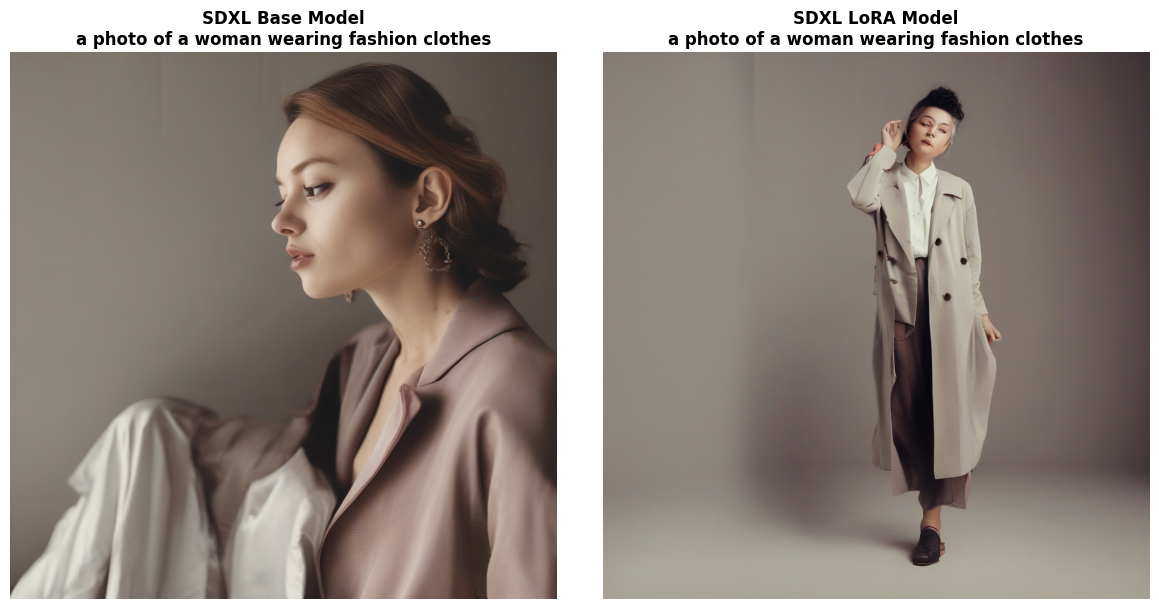


=== 이미지 비교 결과 ===
프롬프트: a photo of a woman wearing fashion clothes
베이스 모델 이미지 크기: (1024, 1024)
LoRA 모델 이미지 크기: (1024, 1024)
모델 타입: SDXL


In [10]:
# 첫 번째 프롬프트로 테스트
prompt = test_prompts[0]
print(f"\n=== 테스트 프롬프트: {prompt} ===")

# 베이스 모델로 이미지 생성
print("\n1. 베이스 모델로 이미지 생성 중...")
if MODEL_TYPE == "SD":
    base_image = generate_sd_image(base_model, prompt, **params)
else:
    base_image = generate_sdxl_image(base_model, prompt, **params)

# LoRA 모델로 이미지 생성
print("\n2. LoRA 모델로 이미지 생성 중...")
if MODEL_TYPE == "SD":
    lora_image = generate_sd_image(lora_model, prompt, **params)
else:
    lora_image = generate_sdxl_image(lora_model, prompt, **params)

# 결과 비교
compare_images(base_image, lora_image, prompt, MODEL_TYPE)


테스트 2: a photo of a fashion model in street style
베이스 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:11<00:00,  2.66it/s]


LoRA 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


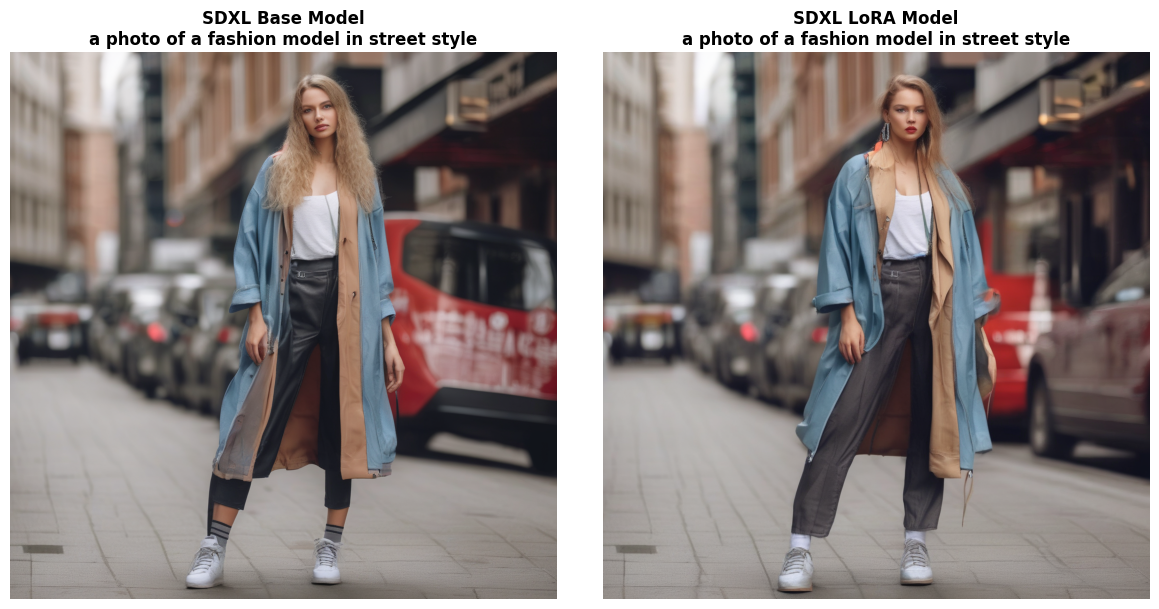


=== 이미지 비교 결과 ===
프롬프트: a photo of a fashion model in street style
베이스 모델 이미지 크기: (1024, 1024)
LoRA 모델 이미지 크기: (1024, 1024)
모델 타입: SDXL

테스트 3: a photo of a person wearing trendy outfit
베이스 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


LoRA 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


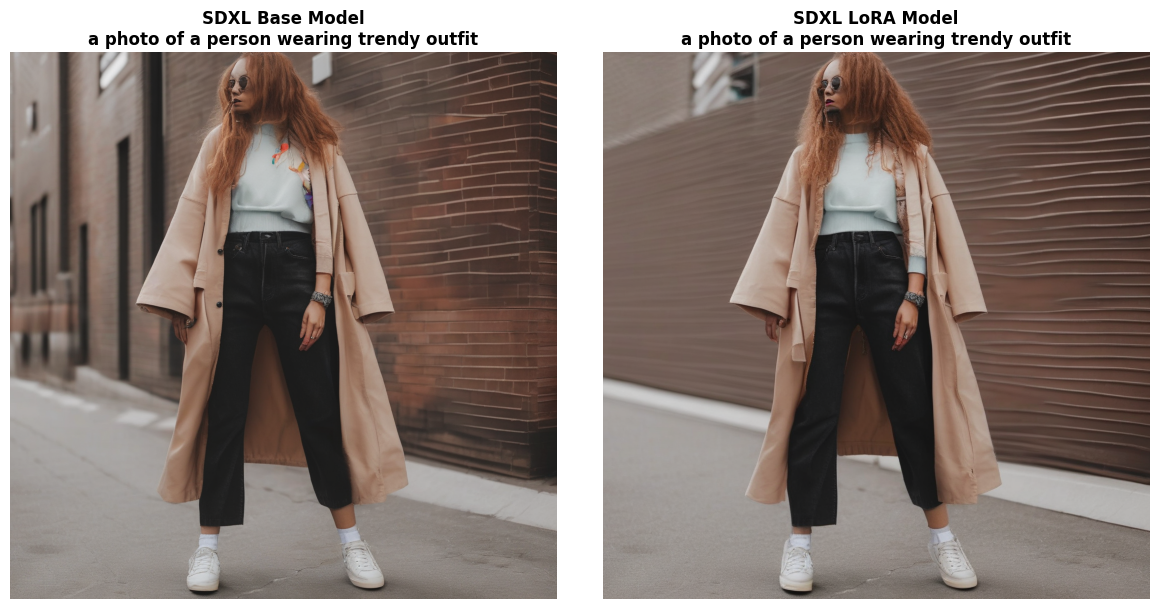


=== 이미지 비교 결과 ===
프롬프트: a photo of a person wearing trendy outfit
베이스 모델 이미지 크기: (1024, 1024)
LoRA 모델 이미지 크기: (1024, 1024)
모델 타입: SDXL

테스트 4: a photo of a woman in casual fashion
베이스 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:12<00:00,  2.50it/s]


LoRA 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


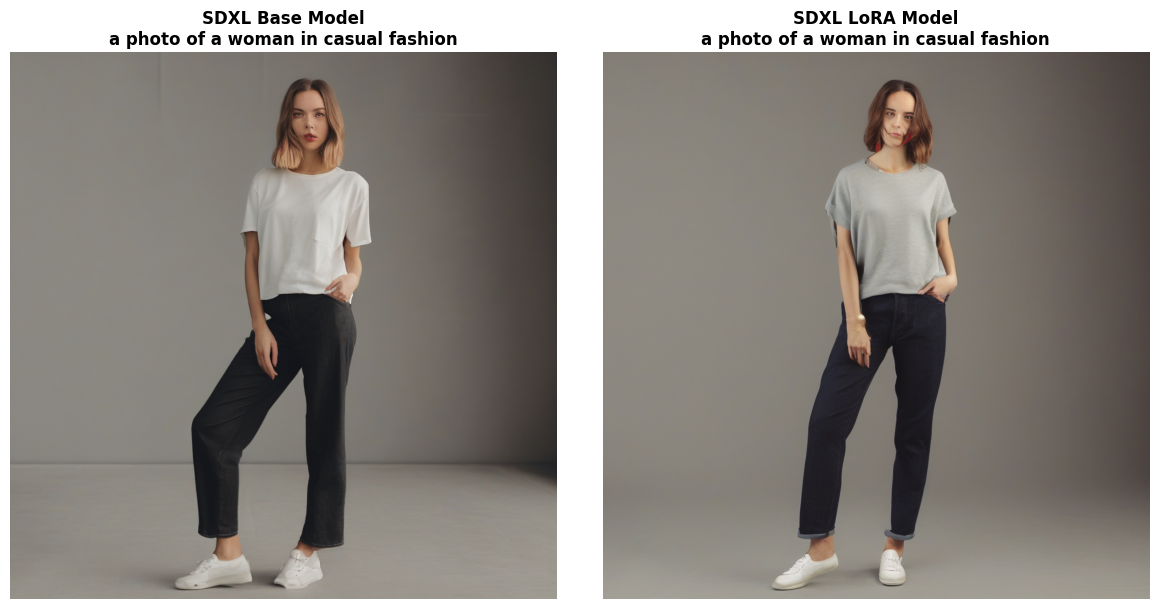


=== 이미지 비교 결과 ===
프롬프트: a photo of a woman in casual fashion
베이스 모델 이미지 크기: (1024, 1024)
LoRA 모델 이미지 크기: (1024, 1024)
모델 타입: SDXL


In [11]:
# 여러 프롬프트로 테스트
for i, prompt in enumerate(test_prompts[1:], 1):
    print(f"\n{'='*60}")
    print(f"테스트 {i+1}: {prompt}")
    print(f"{'='*60}")
    
    # 베이스 모델로 이미지 생성
    print("베이스 모델로 이미지 생성 중...")
    if MODEL_TYPE == "SD":
        base_image = generate_sd_image(base_model, prompt, **params)
    else:
        base_image = generate_sdxl_image(base_model, prompt, **params)

    # LoRA 모델로 이미지 생성
    print("LoRA 모델로 이미지 생성 중...")
    if MODEL_TYPE == "SD":
        lora_image = generate_sd_image(lora_model, prompt, **params)
    else:
        lora_image = generate_sdxl_image(lora_model, prompt, **params)

    # 결과 비교
    compare_images(base_image, lora_image, prompt, MODEL_TYPE)

In [15]:
# 사용자 정의 프롬프트 테스트 함수
def test_custom_prompt(prompt: str, negative_prompt: str = "", 
                      guidance_scale: float = 7.5, 
                      cross_attention_scale: float = 0.5):
    """사용자 정의 프롬프트로 베이스 모델과 LoRA 모델 비교"""
    
    print(f"\n=== 사용자 정의 프롬프트 테스트 ===")
    print(f"프롬프트: {prompt}")
    print(f"네거티브 프롬프트: {negative_prompt if negative_prompt else '(없음)'}")
    
    # 파라미터 설정
    test_params = params.copy()
    test_params.update({
        "guidance_scale": guidance_scale,
        "cross_attention_scale": cross_attention_scale,
        "negative_prompt": negative_prompt
    })
    
    # 베이스 모델로 이미지 생성
    print("\n1. 베이스 모델로 이미지 생성 중...")
    if MODEL_TYPE == "SD":
        base_image = generate_sd_image(base_model, prompt, **test_params)
    else:
        base_image = generate_sdxl_image(base_model, prompt, **test_params)

    # LoRA 모델로 이미지 생성
    print("\n2. LoRA 모델로 이미지 생성 중...")
    if MODEL_TYPE == "SD":
        lora_image = generate_sd_image(lora_model, prompt, **test_params)
    else:
        lora_image = generate_sdxl_image(lora_model, prompt, **test_params)

    # 결과 비교
    compare_images(base_image, lora_image, prompt, MODEL_TYPE)
    
    return base_image, lora_image


=== 사용자 정의 프롬프트 테스트 ===
프롬프트: a photo of a woman wearing elegant dress in urban setting
네거티브 프롬프트: blurry, low quality, distorted

1. 베이스 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]



2. LoRA 모델로 이미지 생성 중...


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


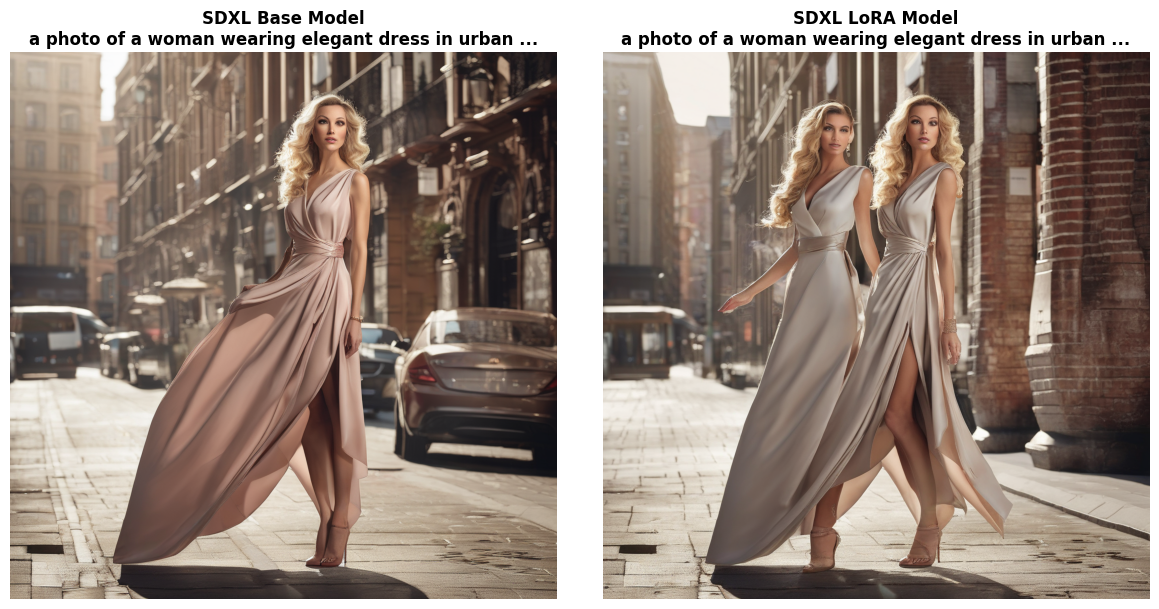


=== 이미지 비교 결과 ===
프롬프트: a photo of a woman wearing elegant dress in urban setting
베이스 모델 이미지 크기: (1024, 1024)
LoRA 모델 이미지 크기: (1024, 1024)
모델 타입: SDXL


In [16]:
# 예시: 사용자 정의 프롬프트 테스트
# 아래 프롬프트를 원하는 것으로 변경하여 테스트하세요

custom_prompt = "a photo of a woman wearing elegant dress in urban setting"
custom_negative = "blurry, low quality, distorted"

base_img, lora_img = test_custom_prompt(
    prompt=custom_prompt,
    negative_prompt=custom_negative,
    guidance_scale=8.0,
    cross_attention_scale=0.6
)

In [17]:
# 성능 분석 요약
print("\n" + "="*60)
print("🎯 LoRA 모델 성능 분석 요약")
print("="*60)

print("\n📊 주요 관찰사항:")
print("1. 베이스 모델 vs LoRA 모델 비교")
print("   - 베이스 모델: 일반적인 패션 이미지 생성")
print("   - LoRA 모델: 훈련 데이터에 특화된 스타일 생성")

print("\n2. 파라미터 영향:")
print("   - Guidance Scale: 높을수록 프롬프트 준수도 증가")
print("   - Cross Attention Scale: 높을수록 LoRA 영향 증가")
print("   - Negative Prompt: 이미지 품질 개선에 도움")

print("\n3. 최적 파라미터 추천:")
print(f"   - Guidance Scale: 7.5-10.0")
print(f"   - Cross Attention Scale: 0.5-0.7")
print(f"   - Steps: 30-50 (테스트용/품질용)")

print("\n4. 사용 팁:")
print("   - 패션 관련 프롬프트에서 LoRA 효과가 가장 뚜렷함")
print("   - 네거티브 프롬프트로 품질 개선 가능")
print("   - 다양한 파라미터 조합으로 실험 권장")

print("\n✅ LoRA 모델이 성공적으로 훈련되었으며, 베이스 모델 대비 특화된 스타일을 생성합니다!")


🎯 LoRA 모델 성능 분석 요약

📊 주요 관찰사항:
1. 베이스 모델 vs LoRA 모델 비교
   - 베이스 모델: 일반적인 패션 이미지 생성
   - LoRA 모델: 훈련 데이터에 특화된 스타일 생성

2. 파라미터 영향:
   - Guidance Scale: 높을수록 프롬프트 준수도 증가
   - Cross Attention Scale: 높을수록 LoRA 영향 증가
   - Negative Prompt: 이미지 품질 개선에 도움

3. 최적 파라미터 추천:
   - Guidance Scale: 7.5-10.0
   - Cross Attention Scale: 0.5-0.7
   - Steps: 30-50 (테스트용/품질용)

4. 사용 팁:
   - 패션 관련 프롬프트에서 LoRA 효과가 가장 뚜렷함
   - 네거티브 프롬프트로 품질 개선 가능
   - 다양한 파라미터 조합으로 실험 권장

✅ LoRA 모델이 성공적으로 훈련되었으며, 베이스 모델 대비 특화된 스타일을 생성합니다!


In [18]:
# 이미지 저장 함수
def save_comparison_images(base_image: Image.Image, lora_image: Image.Image, 
                          prompt: str, model_type: str = "SDXL", 
                          save_dir: str = "../generated_comparisons/"):
    """비교 이미지들을 저장"""
    
    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    
    # 파일명 생성
    safe_prompt = prompt[:30].replace(' ', '_').replace(',', '')
    timestamp = str(int(torch.rand(1).item() * 10000))
    
    base_filename = f"{save_dir}{model_type}_base_{safe_prompt}_{timestamp}.png"
    lora_filename = f"{save_dir}{model_type}_lora_{safe_prompt}_{timestamp}.png"
    
    # 이미지 저장
    base_image.save(base_filename)
    lora_image.save(lora_filename)
    
    print(f"\n💾 이미지 저장 완료:")
    print(f"   베이스 모델: {base_filename}")
    print(f"   LoRA 모델: {lora_filename}")
    
    return base_filename, lora_filename

# 예시: 마지막 생성된 이미지들 저장
if 'base_img' in locals() and 'lora_img' in locals():
    save_comparison_images(base_img, lora_img, custom_prompt, MODEL_TYPE)


💾 이미지 저장 완료:
   베이스 모델: ../generated_comparisons/SDXL_base_a_photo_of_a_woman_wearing_ele_4277.png
   LoRA 모델: ../generated_comparisons/SDXL_lora_a_photo_of_a_woman_wearing_ele_4277.png
